# XAI Metrics based on Global Feature Importance

This tutorial explores the use of global feature importance for calculating explainability metrics. Both metrics and visualizations are presented in this guide. Criteria such as importance contraction and fluctuation of individual conditional expectation are metrics that help us understand the complexity of the relationship between the feature and the model's decision-making process.

In [1]:
from holisticai.utils import BinaryClassificationProxy
from sklearn.ensemble import RandomForestClassifier

from holisticai.datasets import load_dataset

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

from sklearn.pipeline import Pipeline

from holisticai.inspection import compute_partial_dependence
from holisticai.utils.feature_importances import compute_permutation_importance, compute_conditional_permutation_feature_importance
from holisticai.explainability.metrics import classification_global_feature_importance_explainability_metrics
from holisticai.utils.data_preprocessor import simple_preprocessor
from holisticai.efficacy.metrics import classification_efficacy_metrics

# Regression (US Crime Dataset)

load and preprocessing US Crime Dataset

In [16]:
ds = load_dataset('us_crime', preprocessed=False)
dataset = ds.train_test_split(test_size=0.2, random_state=42)

train = dataset['train']
test = dataset['test']

Xt_train, Xt_test, yt_train, yt_test = simple_preprocessor(train['X'], test['X'], train['y'], test['y'], categorical_types=['object'], model_type='regression', only_numerics=True)

Train the model and measure efficacy

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from holisticai.utils import RegressionProxy
from holisticai.efficacy.metrics import regression_efficacy_metrics
from holisticai.utils import concatenate_metrics

model = GradientBoostingRegressor()
model.fit(Xt_train, yt_train)
proxy = RegressionProxy(predict=model.predict)

y_pred_test = model.predict(Xt_test)
efficacy_metrics =regression_efficacy_metrics(yt_test, y_pred_test)
efficacy_metrics

,Value,Reference
Metric,,
RMSE,1.383026e-01,0
MAE,8.913913e-02,0
MAPE,1.374844e+12,0
Max Error,7.582146e-01,0
SMAPE,2.346846e-01,0


Compute feature importance and partial dependence

In [18]:
importances  = compute_permutation_importance(X=Xt_test, y=yt_test, proxy=proxy)

conditional_feature_importances  = compute_conditional_permutation_feature_importance(X=Xt_test, y=yt_test, proxy=proxy)

top_n = 5
top_feature_names = importances.top_n(top_n).feature_names
partial_dependencies = compute_partial_dependence(Xt_test, features=top_feature_names, proxy=proxy)

Compute Global Feature Importance XAI Metrics

In [19]:
global_metrics = classification_global_feature_importance_explainability_metrics(partial_dependencies, importances, conditional_feature_importances,top_n=top_n)
global_metrics

,Value,Reference
Spread Divergence,0.686133,1
Fluctuation Ratio,0.12388,0
Rank Alignment,0.272962,1
Alpha Score,0.138614,0


In [20]:
partial_dependencies

{"dtype":"Partial Dependence","attributes":{"Number of Features":5,"Number of Labels":1,"Elements":["individual","average","grid_values"],"key":"[label_idx, feature_idx, element]"}}

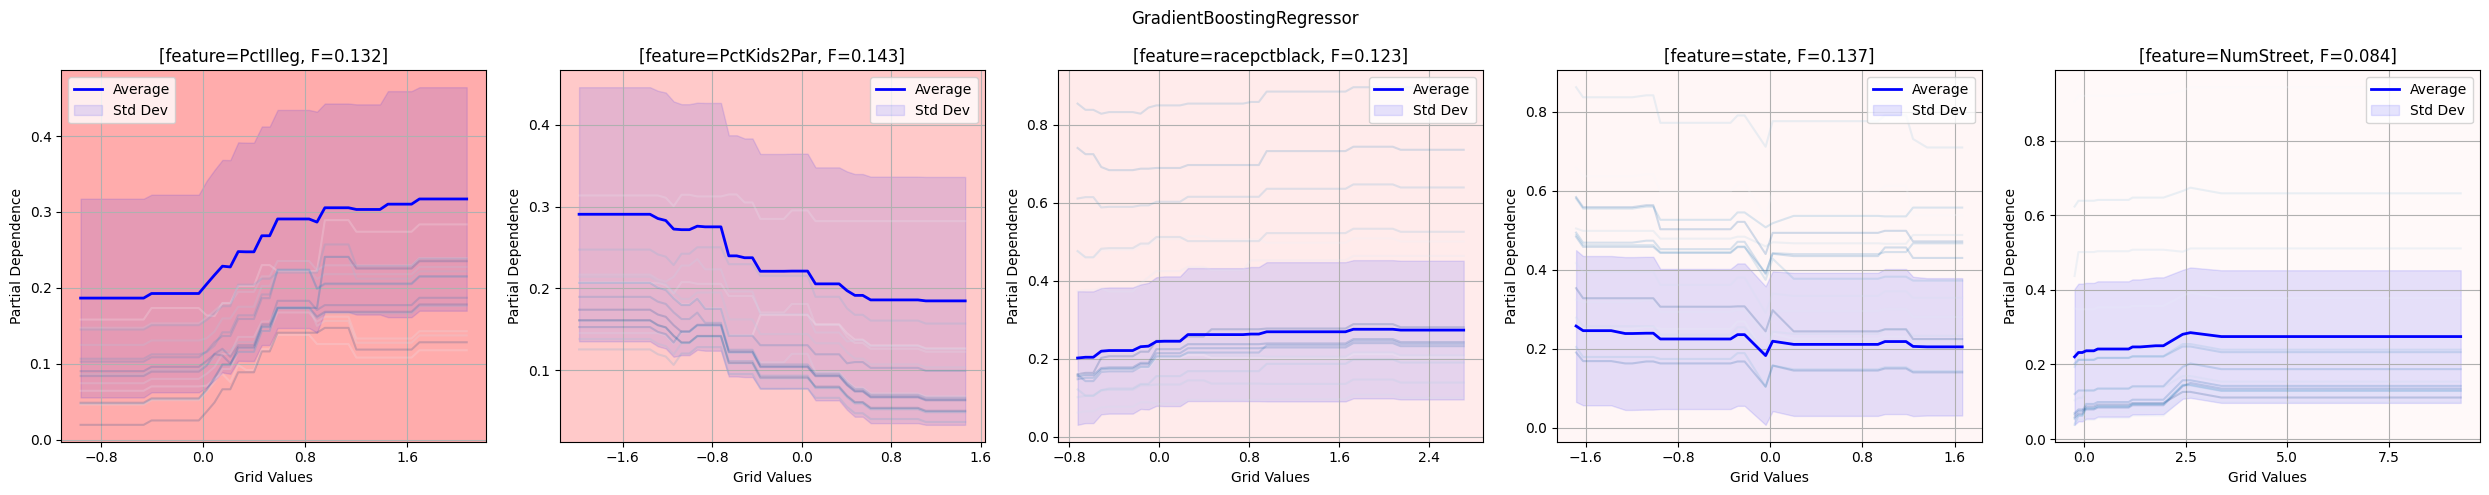

In [21]:
from holisticai.explainability.plots import plot_explainable_partial_dependence

plot_explainable_partial_dependence(partial_dependencies, 
                                    importances, 
                                    figsize=(25,5), 
                                    feature_names=partial_dependencies.feature_names, 
                                    model_name='GradientBoostingRegressor', 
                                    top_n=5)

<Axes: title={'center': 'Feature Importance'}, xlabel='Importance', ylabel='Features'>

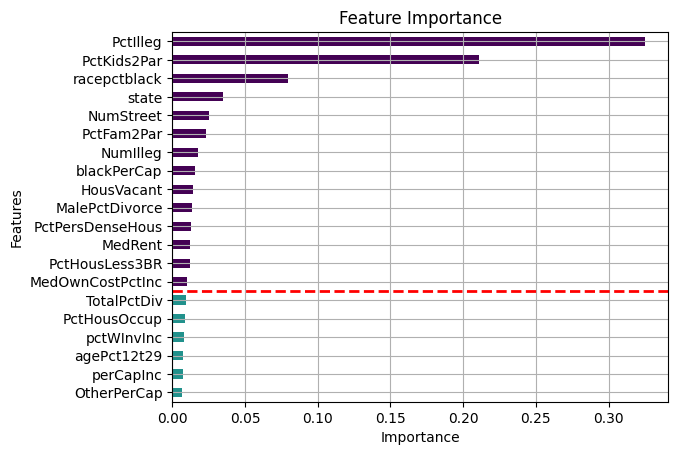

In [22]:
from holisticai.explainability.plots import plot_feature_importance
plot_feature_importance(importances, alpha=0.8, top_n=20)

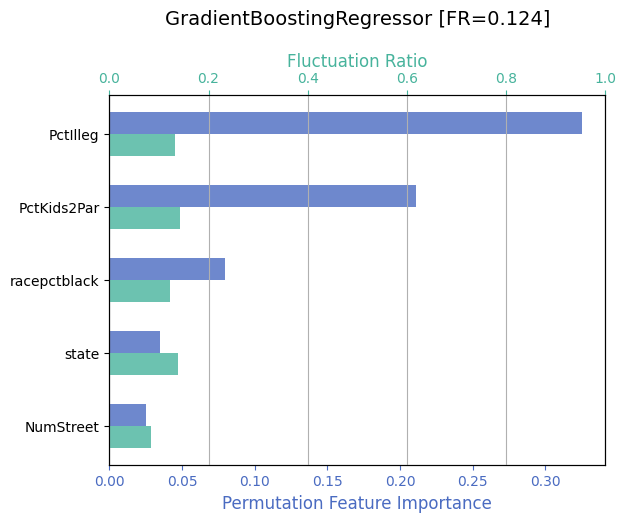

In [23]:
from holisticai.explainability.plots import plot_top_explainable_global_feature_importances
plot_top_explainable_global_feature_importances(partial_dependencies, 
                                                importances, 
                                                model_name="GradientBoostingRegressor", 
                                                top_n=top_n)